In [1]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


In [2]:
figformat = 'svg'

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

dataset_load.models = models
dataset_load.counts = dataset_load.npred()

In [4]:
edispKernelMap = dataset_load.edisp
edispKernel = edispKernelMap.get_edisp_kernel()
edispMap = edispKernelMap.edisp_map

In [5]:
from astropy.visualization import quantity_support

def plot(edispKernel_, ax=None):
    ax = plt.gca() if ax is None else ax
    kwargs =dict()
    kwargs.setdefault("cmap", "GnBu")
    from matplotlib.colors import PowerNorm

    norm = PowerNorm(gamma=0.5, vmin=0, vmax=1)
    kwargs.setdefault("norm", norm)


    energy_axis_true = edispKernel.axes["energy_true"]
    energy_axis = edispKernel.axes["energy"]

    with quantity_support():
        caxes = ax.pcolormesh(
            energy_axis_true.edges, energy_axis.edges, edispKernel_.data.T, **kwargs
        )

    label = "Probability density (A.U.)"
    ax.figure.colorbar(caxes, ax=ax, label=label)

    energy_axis_true.format_plot_xaxis(ax=ax)
    energy_axis.format_plot_yaxis(ax=ax)
    return ax

Text(0.5, 1.0, 'Edisp')

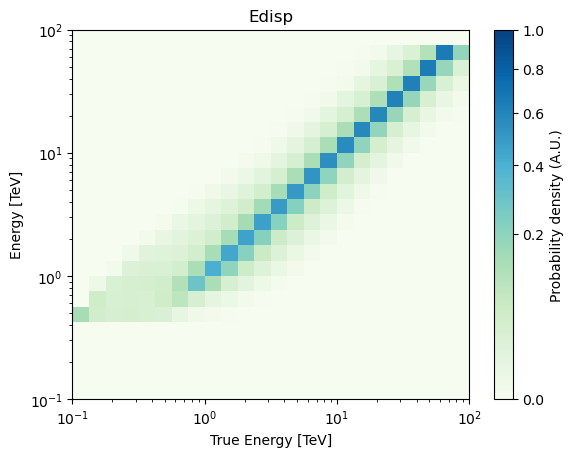

In [6]:
ax = plot(edispKernel)
ax.set_title(f'Edisp')

In [7]:
from gammapy.maps import MapAxis
from gammapy.irf import EDispKernel, EDispKernelMap
def get_gaussian_kernel(bias, sigma):
    edisp_kernel = EDispKernel.from_gauss(
        energy_axis_true=energy_true, energy_axis=energy, sigma=sigma, bias=bias
    )
    return edisp_kernel

b= 0.0 s= 1e-13
b= 0.0 s= 0.1
b= 0.0 s= 0.5
b= 0.0 s= 0.8


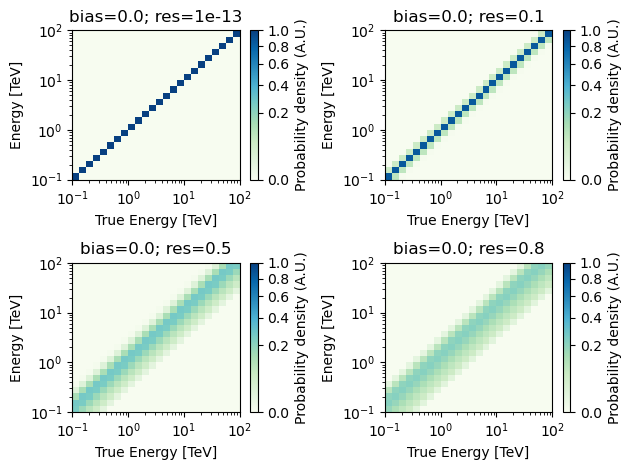

In [78]:
energy = edispKernel.axes['energy']
energy_true = edispKernel.axes['energy_true']

fig, axs = plt.subplots(2,2)
axs = axs.flatten()
delta = 1e-2
biass = [0.0]
sigmass = [1e-13, 0.1, 0.5, 0.8]

i = 0

for b in biass:
    for s in sigmass:
        print("b=", b, "s=", s)
        gaussian = get_gaussian_kernel(bias = b, sigma = s)
        plot(gaussian,axs[i])
        axs[i].set_title(f'bias={b}; res={s}')
        i +=1
plt.tight_layout()

fig.savefig(f"plots/1_Gaussians."+figformat)

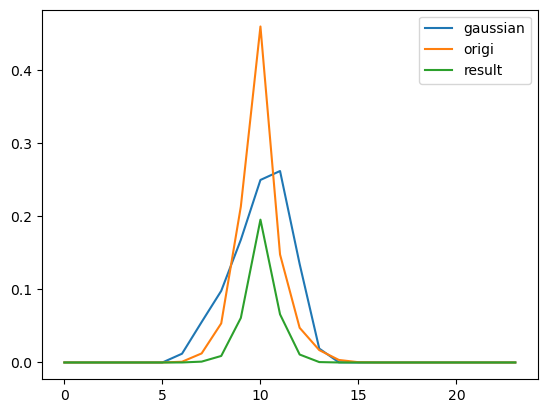

In [79]:
gaussian = get_gaussian_kernel(bias = 0, sigma = 0.5)

plt.plot(gaussian.data.T[:,10], label = 'gaussian')
plt.plot(edispKernel.data.T[:,10], label = 'origi')

plt.plot(gaussian.data.T[:,10] * edispKernel.data.T[:,10]* 1.7, label = 'result')
plt.legend()

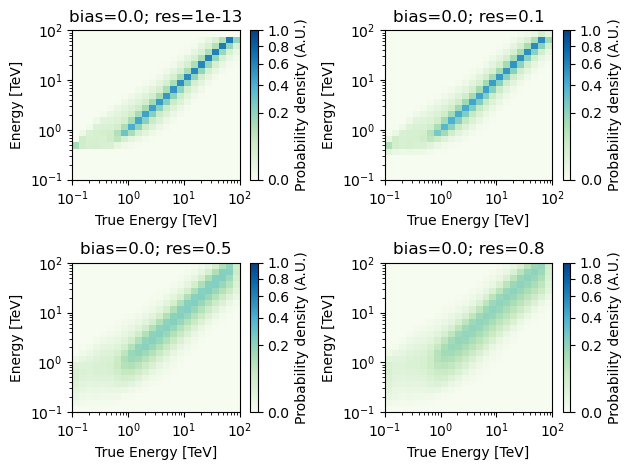

In [80]:
convs = []
fig, axs = plt.subplots(2,2)
axs = axs.flatten()

i = 0

for b in biass:
    for s in sigmass:
        gaussian = get_gaussian_kernel(bias = b, sigma = s)
        conv = EDispKernel(
         axes = edispKernel.axes,
         data = np.matmul(edispKernel.data, gaussian.data) )
        
        plot(conv,axs[i])
        axs[i].set_title(f'bias={b}; res={s}')
        i +=1
        convs.append(conv)
plt.tight_layout()

fig.savefig(f"plots/1_Edisps."+figformat)

In [81]:
def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        sigma = s,
                        rnd = False)
    dataset_conv = sys_d_cor.create_dataset()
    return dataset_conv
datasets_conv = []
for b in biass:
    for s in sigmass:
        d = create_dataset(b,s )
        datasets_conv.append(d)


In [82]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_load.geoms['geom'].axes[0]

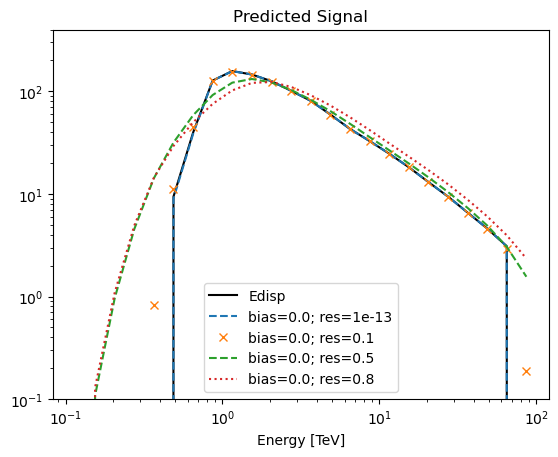

In [83]:
plt.title("Predicted Signal")
i = 0 
fmts = ['--', 'x', '--', ':']
plt.plot(eaxis_standard.center, 
         sum_e(dataset_load.counts.data-dataset_load.background.data),
         label = "Edisp",color = 'black')
for b in biass:
    for s in sigmass:
        plt.plot(eaxis_standard.center, sum_e(datasets_conv[i].counts.data-datasets_conv[i].background.data),
                 fmts[i], label = f"bias={b}; res={s}")
        i += 1
        
#for d in datasets_conv:
#    plt.plot(eaxis_standard.center, sum_e(d.npred_signal().data), '-',
#         label = f"Edisp * \n b={bias}; s={sigma}")
plt.ylim(1e-1, 4e2)
plt.loglog()
plt.legend()
plt.xlabel("Energy [TeV]")
fig = plt.gcf()
fig.savefig(f"plots/1_Npred_bias={bias}sigma={sigma}."+figformat)

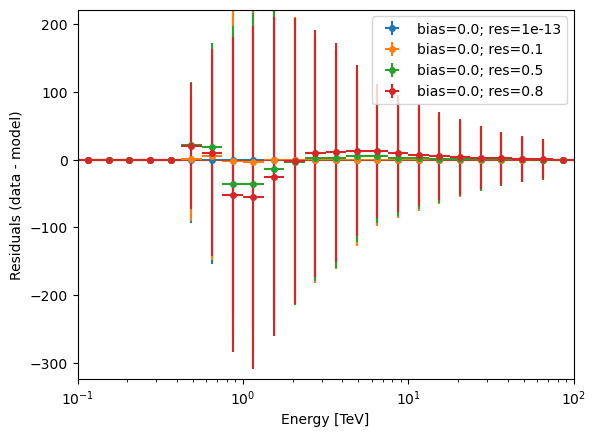

In [84]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()
fig.savefig(f"plots/1_Residual_bias={bias}sigma={sigma}."+figformat)

In [85]:
print("corr")
fit_cor = Fit(store_trace=False)
for d in datasets_conv:
    result_cor = fit_cor.run(d)
    

        

corr


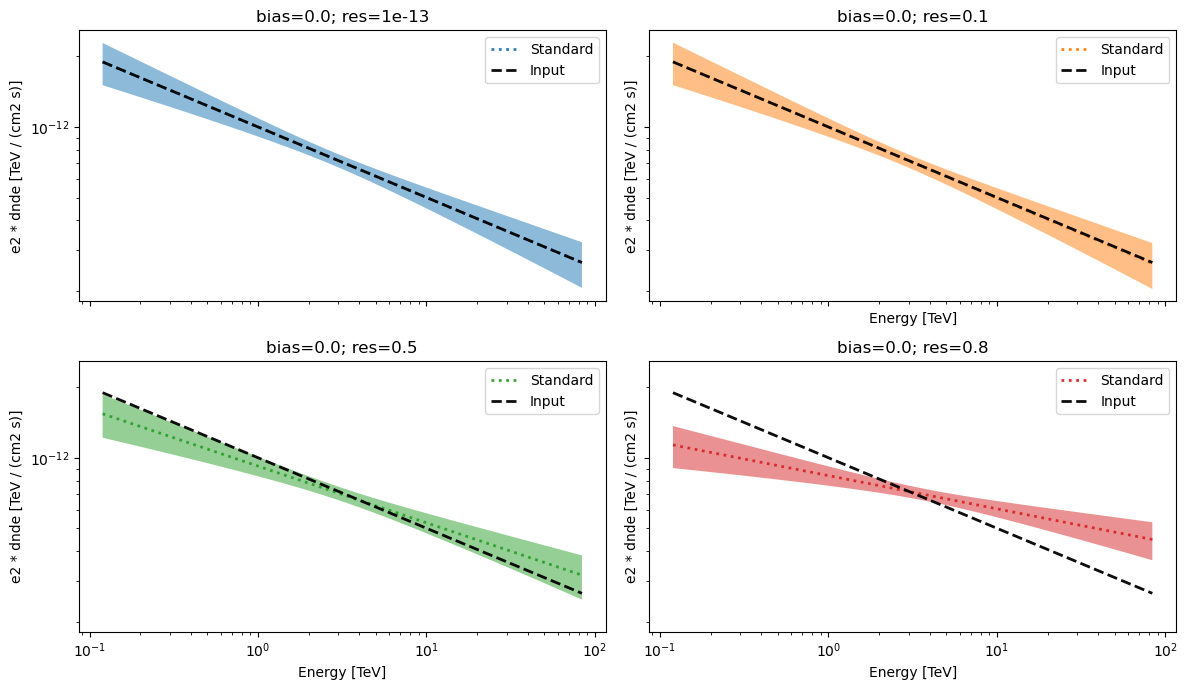

In [86]:
energy = dataset_conv.counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV


fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv[i]
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               color=colors[ii],
                                                                 label= f"Standard",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       
        
      

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               facecolor=colors[ii],
                                                                 label="",
                                                                alpha = 0.5)
        axs[ii].set_title(f"bias={b}; res={s}")
        i +=1
        ii +=1
for a in axs:
    dataset_load.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                               color='black',
                                                                 label="Input",
                                                                alpha = 0.95,
                                                               linestyle='dashed', linewidth= 2)  
    a.legend()
    
ylim = axs[0].get_ylim()
axs[1].set_ylim(ylim[0], ylim[1])
axs[0].set_xlabel('')
plt.tight_layout()
fig.savefig(f"plots/1_Spectrum_bias={bias}sigma={sigma}."+figformat)

['B=0.0;\n R=1e-13', 'B=0.0;\n R=0.1', 'B=0.0;\n R=0.5', 'B=0.0;\n R=0.8']


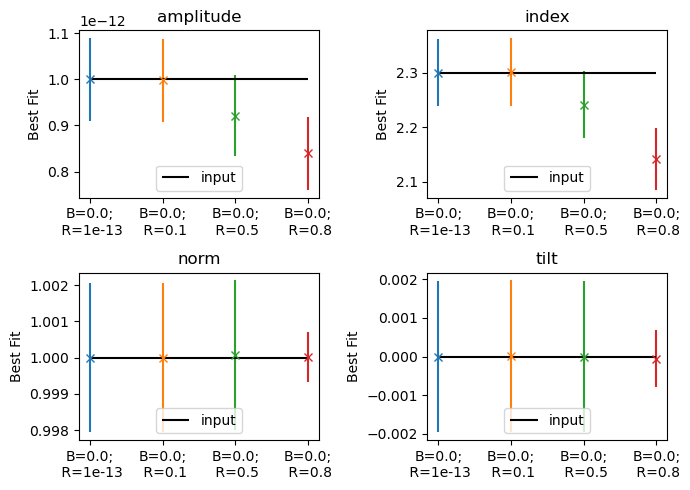

In [87]:
fig,ax  = plt.subplots(2,2,figsize= (7, 5))
ax = ax.flatten()
parnames = ['amplitude', 'index', 'norm', 'tilt']
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'x')
        ii +=1
        labels_sys.append(f'B={b};\n R={s}')
print(labels_sys)        
for i, p in enumerate(parnames):
    value = dataset_load.models.parameters[p].value
    error = dataset_load.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, 3, label = "input", color= 'black')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(4),labels_sys)
    
plt.tight_layout()
    